# import

In [89]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

from statsmodels.tsa.seasonal import seasonal_decompose 


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from catboost import Pool

DATA_PATH = 'taxi.csv'
#DATA_PATH = '/datasets/taxi.csv'

In [2]:
df = pd.read_csv(DATA_PATH)

# first look EDA 

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [9]:
df['datetime'] = df['datetime'].astype('datetime64')
df.set_index('datetime', inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:title={'center':'orders distribution'}>

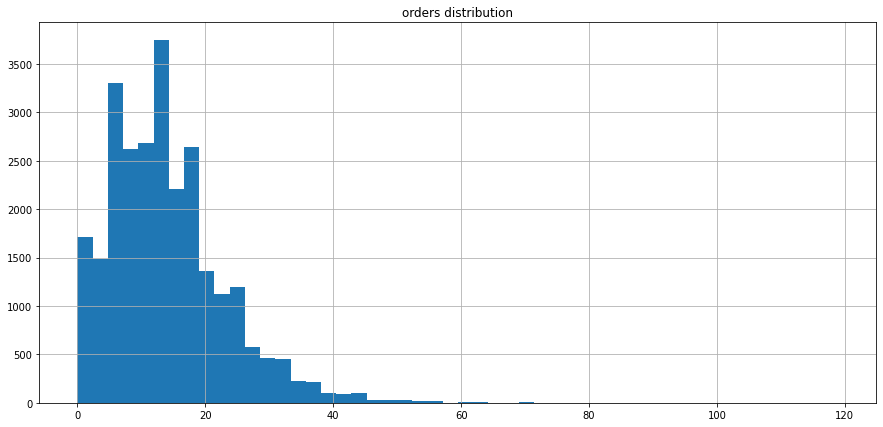

In [10]:
#plt.figure(figsize=(12,5))
plt.title('orders distribution')
df['num_orders'].hist(bins = 50)

<AxesSubplot:title={'center':'orders in dynamics'}, xlabel='datetime', ylabel='num of orders'>

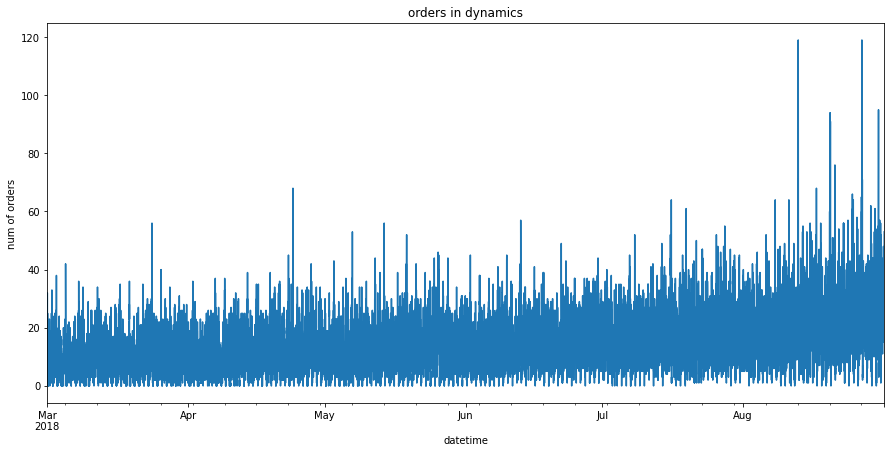

In [12]:
#plt.figure(figsize=(12,5))
plt.title('orders in dynamics')
plt.ylabel('num of orders')
df.num_orders.plot()

Распределение количества заказов смещено сильно вправо + на гафике видно сильные всплески по количеству заказов, что похоже на выбросы.  

In [13]:
df = df.resample('1H').sum()

In [17]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


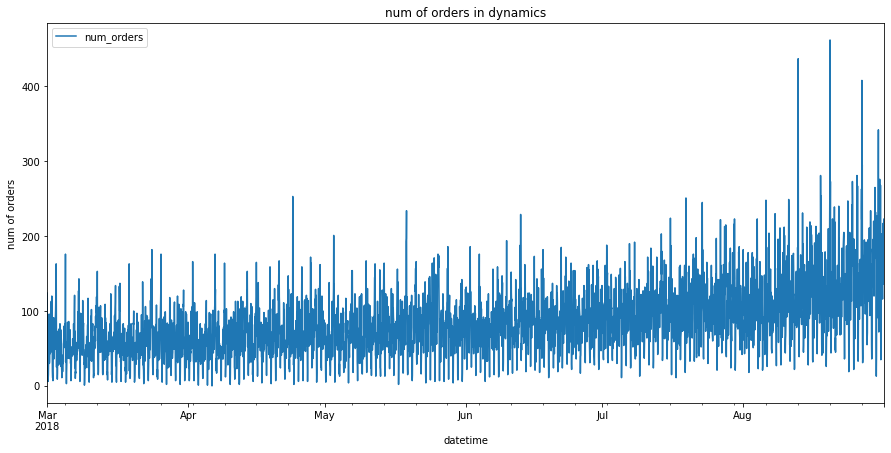

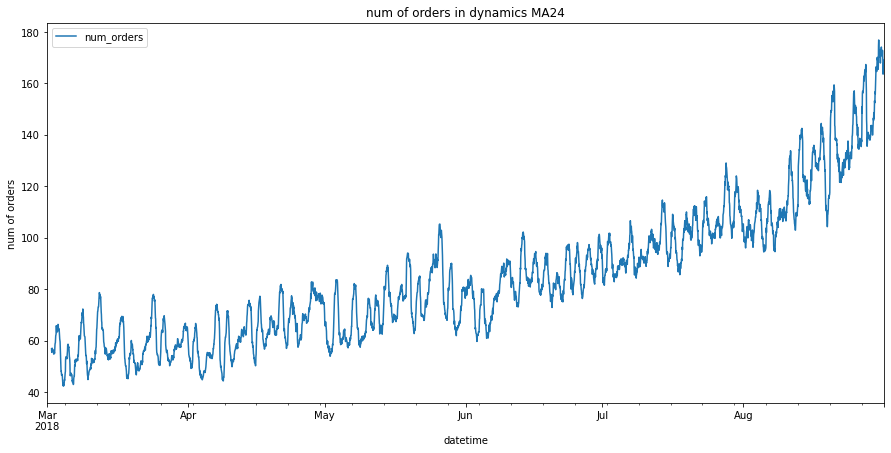

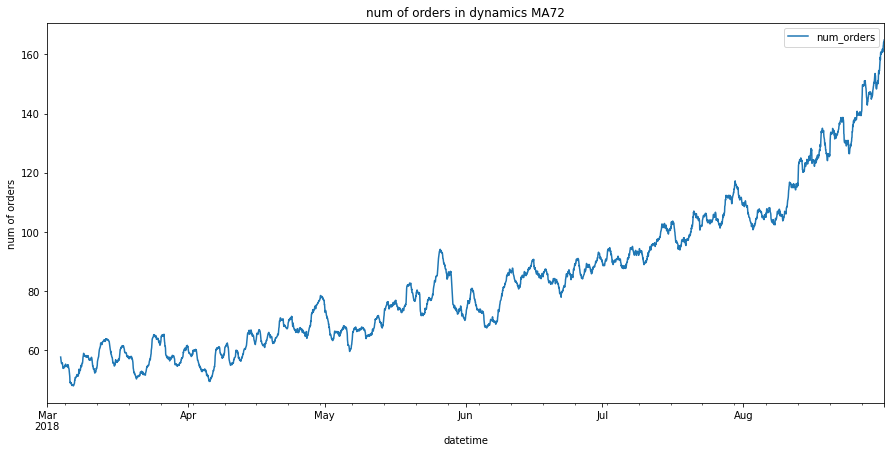

In [26]:
df.plot()
plt.title('num of orders in dynamics')
plt.ylabel('num of orders')

df.rolling(24).mean().plot()
plt.title('num of orders in dynamics MA24')
plt.ylabel('num of orders')

df.rolling(72).mean().plot()
plt.title('num of orders in dynamics MA72')
plt.ylabel('num of orders')

plt.show()

видно, что количество заказов в час сильно увеличивается примерно с июля, появляется тренд. 

In [27]:
#проверка на сортировку индекса
print(df.index.is_monotonic)

True


/var/folders/jy/3_5sjgr138bcfkgnl82l_rvr0000gn/T/ipykernel_60630/2188441590.py:2: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(df.index.is_monotonic)


In [28]:
#посмотрим отдельно на тренд 
decomposed = seasonal_decompose(df)

<AxesSubplot:xlabel='datetime'>

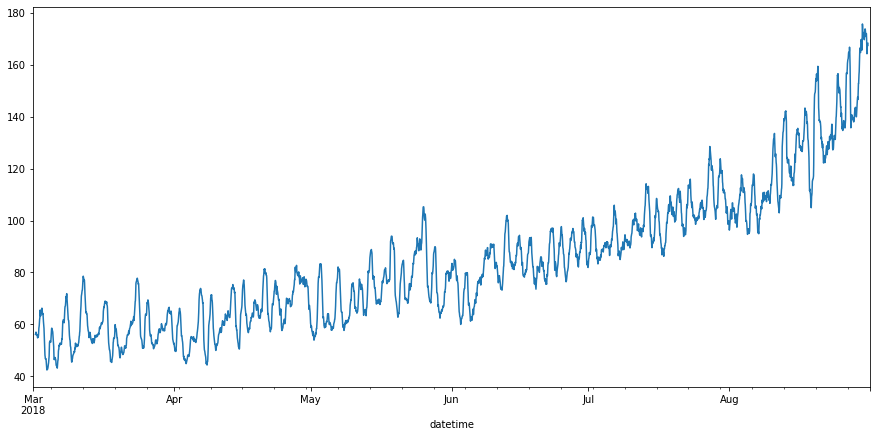

In [29]:
decomposed.trend.plot()

<AxesSubplot:xlabel='datetime'>

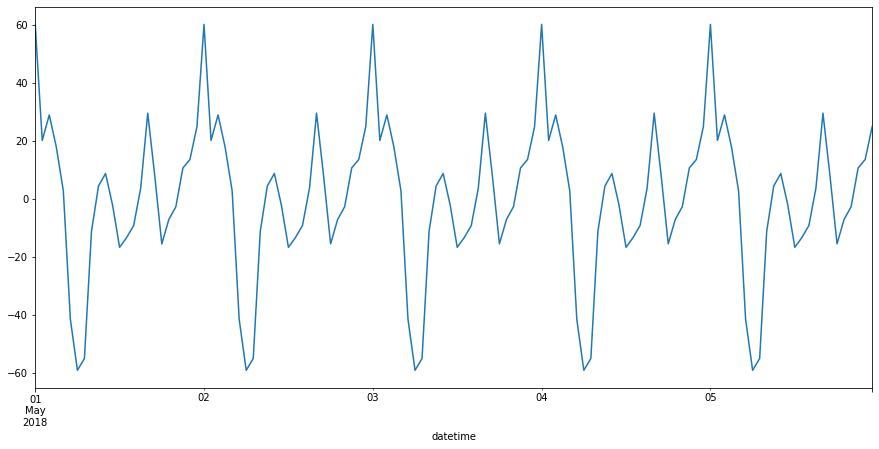

In [30]:
decomposed.seasonal['2018-05-01':'2018-05-05'].plot()


<AxesSubplot:xlabel='datetime'>

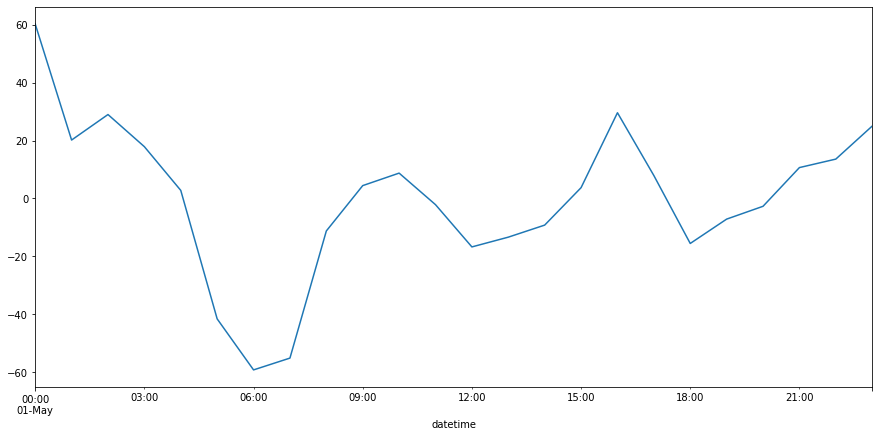

In [31]:
decomposed.seasonal['2018-05-01':'2018-05-01'].plot()

<AxesSubplot:xlabel='datetime'>

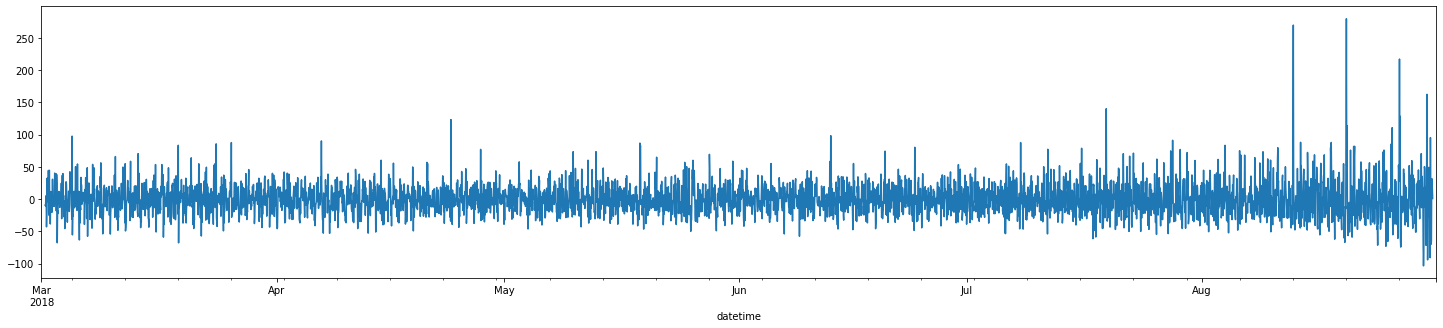

In [32]:
plt.figure(figsize=(25,5))
decomposed.resid.plot()

после августа резко растутт ошибки, которые не относятся ни к тренду, ни к сезонной нагрузке. 
тренд подтверждается визуально, есть еще некотрая сезонность внутри дня: в вечернее врем заказов больше, а ранним утром -- меньше. 

рост ошибок скорее всего связан с выбросами. 

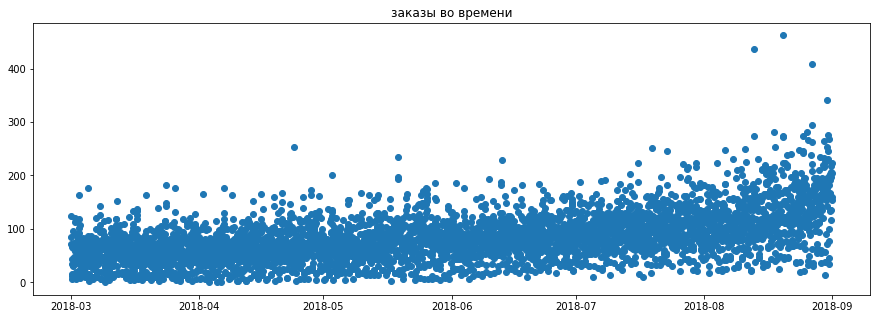

In [34]:
plt.figure(figsize=(15,5))
plt.title('заказы во времени')
plt.scatter(df.index, df.num_orders)
plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Декомпозиция была сделана верно. Хорошо, что сезонность была визуализирована на более коротком интервале!
</div>

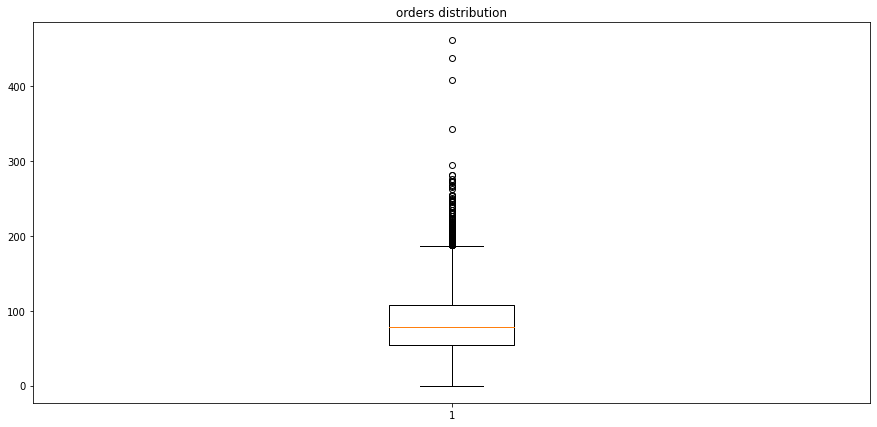

In [41]:
plt.title('orders distribution')
plt.boxplot(df.num_orders)
plt.show()

In [17]:
df.num_orders.describe(percentiles=[0, 0.5, 0.9, 0.95, 0.99])

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
0%          0.000000
50%        78.000000
90%       143.000000
95%       166.000000
99%       223.000000
max       462.000000
Name: num_orders, dtype: float64

за выброс будем считать все, что находится дальше 99-го персентиля.

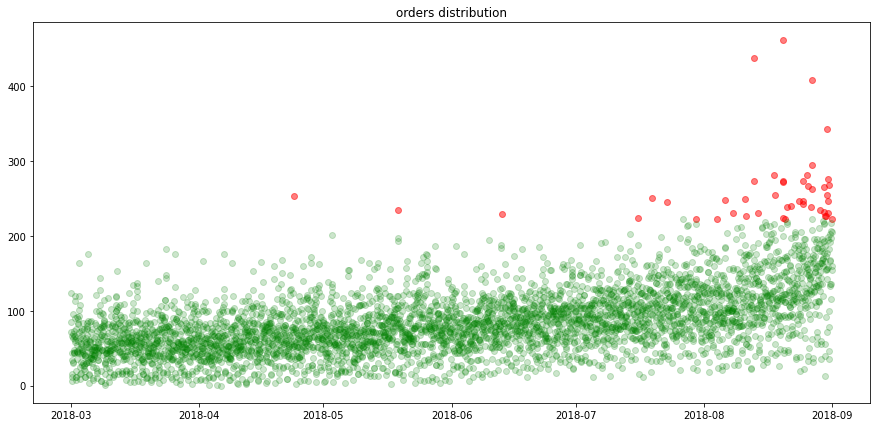

In [67]:
plt.title('orders distribution')
plt.scatter(df.query('num_orders >= 223').index, 
            df.query('num_orders >= 223')['num_orders'], 
            color = 'red', alpha = 0.5)

plt.scatter(df.query('num_orders < 223').index,
            df.query('num_orders < 223')['num_orders'], 
            color = 'green', alpha=0.2)
plt.show()

In [18]:
#df = df[df['num_orders']<= 223]

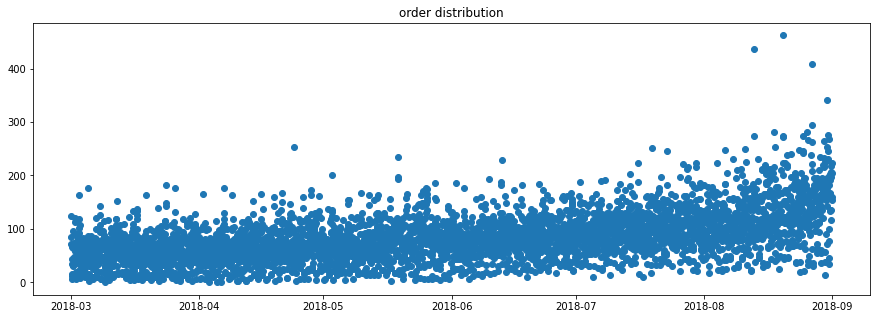

In [69]:
plt.figure(figsize=(15,5))
plt.title('order distribution')
plt.scatter(df.index, df.num_orders)

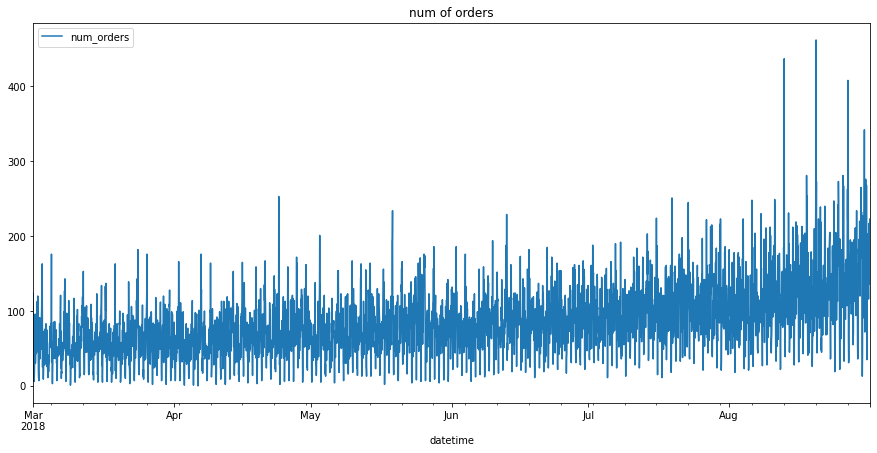

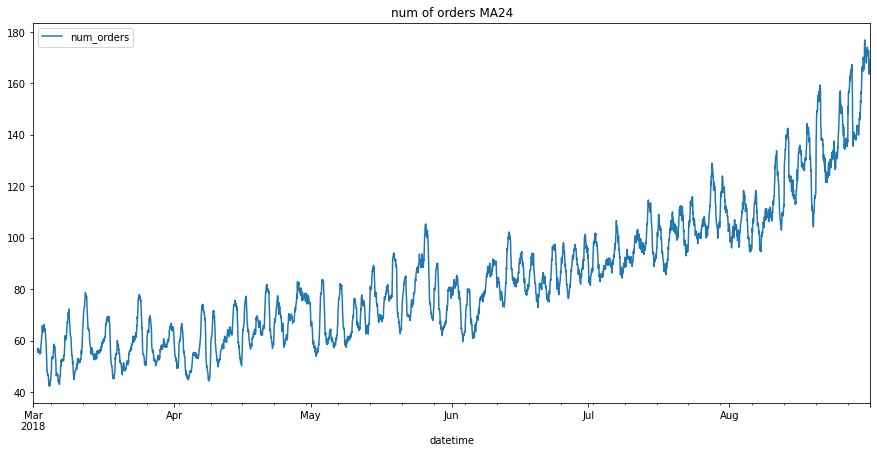

In [73]:
df.plot()
plt.title('num of orders')

df.rolling(24).mean().plot()
plt.title('num of orders MA24')

plt.show()


Тренд остался, но картинка стала немного подекватнее. 

# new features

In [84]:
def get_features(df, parse_date, num_of_lags, list_with_ma, target):
    df_new = df.copy()

    if parse_date == True: 
        #выделим фичи из даты
        df_new['year'] = df_new.index.year
        df_new['month'] = df_new.index.month
        df_new['dayofweek'] = df_new.index.dayofweek
        df_new['day'] = df_new.index.day
        df_new['hour'] = df_new.index.hour
    
    for i in range(1, num_of_lags+1):
        df_new[f'lag_{i}'] = df_new[target].shift(i)

    for i in list_with_ma: 
        df_new[f'ma_{i}'] = df_new[target].shift(1).rolling(i).mean()

    return df_new.dropna()

In [85]:
data = get_features(df, True, 5, [12,24,72], 'num_orders')

In [86]:
data

,num_orders,year,month,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,ma_12,ma_24,ma_72
datetime,,,,,,,,,,,,,,
2018-03-04 00:00:00,75,2018,3,6,4,0,43.0,63.0,48.0,83.0,30.0,50.583333,53.750000,57.777778
2018-03-04 01:00:00,60,2018,3,6,4,1,75.0,43.0,63.0,48.0,83.0,54.166667,50.083333,57.097222
2018-03-04 02:00:00,26,2018,3,6,4,2,60.0,75.0,43.0,63.0,48.0,56.833333,48.083333,56.750000
2018-03-04 03:00:00,42,2018,3,6,4,3,26.0,60.0,75.0,43.0,63.0,55.583333,48.125000,56.125000
2018-03-04 04:00:00,27,2018,3,6,4,4,42.0,26.0,60.0,75.0,43.0,52.750000,47.208333,55.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,4,31,19,207.0,217.0,197.0,116.0,133.0,163.416667,164.875000,162.861111
2018-08-31 20:00:00,154,2018,8,4,31,20,136.0,207.0,217.0,197.0,116.0,170.916667,167.541667,163.208333
2018-08-31 21:00:00,159,2018,8,4,31,21,154.0,136.0,207.0,217.0,197.0,168.583333,168.041667,164.041667


# modeling

In [98]:
train, test = train_test_split(data, test_size=0.2, shuffle= False)

In [99]:
x_train, y_train = train.drop(['num_orders'], axis = 1), train['num_orders']
x_test, y_test = test.drop(['num_orders'], axis = 1), test['num_orders']

## LR

In [101]:
tscv = TimeSeriesSplit(n_splits=5)

lr = LinearRegression()

cv_score = cross_val_score(lr, x_train, y_train, cv = tscv, 
                scoring = 'neg_root_mean_squared_error').mean()*-1

print('cv train', cv_score)

lr.fit(x_train, y_train)

cv train 30.003749027287814


LinearRegression()

результат не очень удовлетворительный на тесте, хотя на трейне ничего. попробуем более сложные модели

## ctb

In [102]:
%%time 

X_train_ctb = x_train.copy()
X_test_ctb = x_test.copy()


model = CatBoostRegressor(loss_function="RMSE", verbose=False)

train_dataset = Pool(data=X_train_ctb, label=y_train )

grid = {'learning_rate': [0.03, 0.05, 0.1],
        'depth': [4, 6, 8, 12],
        'l2_leaf_reg': [1, 3, 5], 
        'iterations': [50, 75, 100, 200]}

model.randomized_search(grid,train_dataset, cv =tscv,  verbose = False)

print('best score', model.best_score_)


bestTest = 30.85788985
bestIteration = 74


bestTest = 28.60323827
bestIteration = 199


bestTest = 28.37771053
bestIteration = 99


bestTest = 26.89092569
bestIteration = 198


bestTest = 31.01876551
bestIteration = 48


bestTest = 30.04393189
bestIteration = 74


bestTest = 32.18366754
bestIteration = 74


bestTest = 41.26855914
bestIteration = 74


bestTest = 35.91262838
bestIteration = 99


bestTest = 32.70263456
bestIteration = 198

Training on fold [0/5]

bestTest = 22.57484715
bestIteration = 124

Training on fold [1/5]

bestTest = 23.74822932
bestIteration = 197

Training on fold [2/5]

bestTest = 23.74084717
bestIteration = 199

Training on fold [3/5]

bestTest = 24.75318196
bestIteration = 115

Training on fold [4/5]

bestTest = 25.87663013
bestIteration = 199

best score {'learn': {'RMSE': 16.803246859041668}}
CPU times: user 50.3 s, sys: 5.31 s, total: 55.6 s
Wall time: 13.9 s


катбуст дает хороший результат на трейне лучше, но уже неплохой результат, который проходит по порогу. 

## rfr

In [103]:
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3,6,8, 10, 12],
}
regr = RandomForestRegressor(random_state=0)

clf = GridSearchCV(regr, parameters, cv = tscv, scoring= 'neg_root_mean_squared_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [3, 6, 8, 10, 12],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_root_mean_squared_error')

In [104]:
clf.best_score_*-1

23.81195189132106

по случайному лесу получилось чуть хуже на трейне

лучшая модель на кросс валидации: катбуст (catboost go brrrr как говорится), посмотрим на нее на тестовой выборке

In [107]:
pred = model.predict(x_test)

print(mean_squared_error(pred, y_test, squared=False))

45.94081656623722


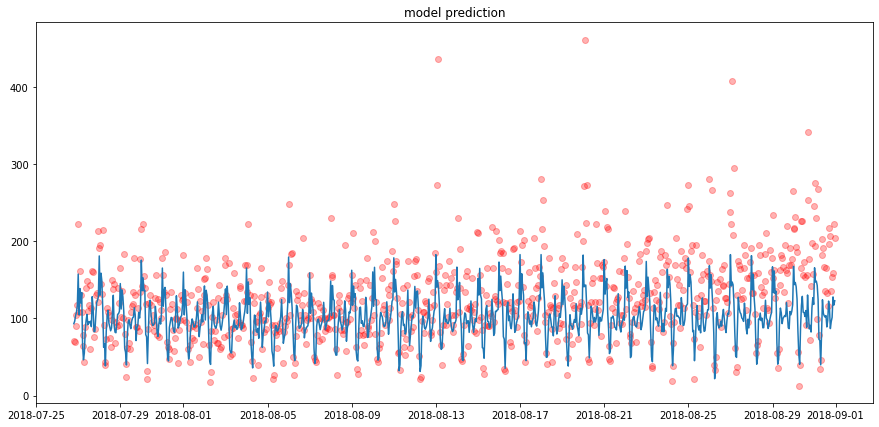

In [115]:
plt.title('model prediction')
plt.scatter(x_test.index, y_test, color = 'red', alpha=0.3)
plt.plot(x_test.index, pred)
plt.show()

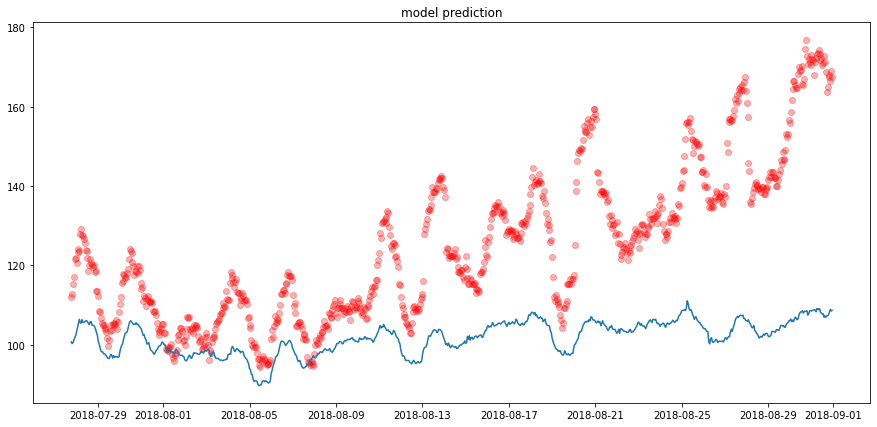

In [123]:
plt.title('model prediction')
plt.scatter(x_test.index, y_test.rolling(24).mean(), color = 'red', alpha=0.3)
plt.plot(x_test.index, pd.Series(pred).rolling(24).mean())
plt.show()

видно, что катбуст неплохо уловил сезонность, внутри дня, но чаще всего ошибается на экстремальных значениях + промахивается при сильном росте числа заказов в августе (может пора отпусоков), данные на тесте и трейне все же сильно отличаются

как варианты для улучшения: 

- взять большие данные для того, чтобы модель могла уловить сезонность (если это она и есть) или тренд (если он продолжится)
- потюнить гиперпараметры и сделать более сложный перебор (тут не будем из-за ограниченности ресуров, но в целом это план)
- попробовать более сложные модели типа саримы (тут они годами будут обучаться, так что пока за скобками)


# выводы

1. Данные не самые чистые, есть выбросы, для их трактовки нужно больше данных о бизнесе (почему мог возникнуть такой резкий скачок заказов)
2. Летом начинается тренд на увеличение заказов. 
3. Есть сезонность внутри дня. 
4. Лучше всего по данным предсказывают модели бустинга и случайного леса. Бустинг обучается быстрее, катбуст стал итоговой моделью. 